In [11]:
#Librerias que necesitamos

import warnings
warnings.filterwarnings("ignore")

import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os

from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

os.chdir("/home/javi/Documents/ReposGit") #Cambiar a directorio en donde se esta trabajando

In [13]:
def nequalize(array,p=5,nodata=0):
    """
    Normaliza una imagen o un conjunto de bandas de una imagen usando ecualizacion de histograma por percentiles.

    Parameters
    ----------
    array : numpy.ndarray
        La imagen o conjunto de bandas a normalizar.
    p : float
        El percentil a utilizar para la ecualizacion.
    nodata : float
        El valor que representa datos faltantes en la imagen.

    Returns
    -------
    numpy.ndarray
        La imagen o conjunto de bandas normalizado.
    """

    #Si la imagen es una sola banda: (alto, ancho) simplemente calcula el percentil y normaliza
    if len(array.shape)==2:
        vmin=np.percentile(array[array!=nodata],p)
        vmax=np.percentile(array[array!=nodata],100-p)
        eq_array = (array-vmin)/(vmax-vmin)
        eq_array[eq_array>1]=1
        eq_array[eq_array<0]=0
    #Si la imagen tiene varias banda: (cantidad de bandas, alto, ancho), hace lo anterior pero para cada banda por separado
    elif len(array.shape)==3:
        eq_array = np.empty_like(array, dtype=float)
        for i in range(array.shape[0]):
            eq_array[i]=nequalize(array[i], p=p, nodata=nodata)
    return eq_array

In [14]:
def plot_rgb(array, band_list , p = 0, nodata = None, figsize = (12,6), title = None):
    '''
    Esta función toma como parámetros de entrada la matriz a ser ploteada, 
    una lista de índices correspondientes a las bandas que queremos usar, 
    en el orden que deben estar (ej: [1,2,3]), y un parámetro p que es opcional 
    que es el percentil de equalización.
    
    Por defecto tambien asigna un tamaño de figura en (12,6), que también puede ser modificado.
    
    Devuelve solamente un ploteo, no modifica el arreglo original.
    Nota: array debe ser una matriz con estas dimensiones de entrada: [bandas, filas, columnas]
    '''
    if not title:
        title = f'Combinación {band_list} \n (percentil {p}%)'
        
    img = nequalize(array[band_list], p=p, nodata=nodata)
    plt.figure(figsize = figsize)
    plt.title(title , size = 20)
    show(img)
    plt.show()    
    
#Elimina los valores de nodata, por defecto los toma como 0 y normaliza por el factor de reflactancia
def delNone(array, nodata = 0, factor=10000): 
    return array[array!=nodata]/factor

In [15]:
def firma_espectral_multipoligono(clase, plot = True, color = "k", ecolor = "r", label = ""):
    '''
    La función toma un archivo con múltiples polígonos (que deben pertenecer a la misma clase) y calcula la firma espectral
    promedio de todos los polígonos.
    
    Las longitudes de onda son las del satélite Sentinel 2 (490nm, 560nm, 665nm, 842nm).
    
    El gráfico de la firma se hace por defecto.
    '''
    for i, shape in enumerate(clase.geometry):
        poligono = shape #geometría del elemento i de shp
        extent = poligono.envelope
        s2_mask, mask_transform  = mask(dataset = s2, shapes = [poligono], crop = True)

        blue = delNone(s2_mask[0],0,10000)
        green = delNone(s2_mask[1],0,10000)
        red = delNone(s2_mask[2],0,10000)
        nir = delNone(s2_mask[3],0,10000)

        [mean_b, mean_g, mean_r, mean_nir] = [np.mean(blue), np.mean(green), np.mean(red), np.mean(nir)]
        [std_b, std_g, std_r, std_nir] = [np.std(blue), np.std(green), np.std(red), np.std(nir)]

        if i==0:
            medias = [mean_b, mean_g, mean_r, mean_nir]
            stds = np.asarray([std_b, std_g, std_r, std_nir])
        else:
            medias = [(medias[0]+mean_b)/2, (medias[1]+mean_g)/2, (medias[2]+mean_r)/2, (medias[3]+mean_nir)/2]
            stds = np.asarray([(stds[0]+std_b)/2, (stds[1]+std_g)/2, (stds[2]+std_r)/2, (stds[3]+std_nir)/2])

        long = [490, 560, 665, 842]

    if plot == True:
        plt.errorbar(long, medias, marker = 'o', yerr = stds, elinewidth = 1, ls = '-.', color = color, ecolor = ecolor, capsize=7,label=label)
        plt.legend()

In [64]:
# resolucion = '20m'
# path = 'Imagenes enero 2021/S2B_MSIL2A_20210117T141739_N0214_R010_T20JLL_20210117T182721.SAFE/GRANULE/L2A_T20JLL_A020199_20210117T142741/IMG_DATA/R'+resolucion+'/'
# r = rasterio.open(path+'T20JLL_20210117T141739_B04_'+resolucion+'.jp2').read()
# g = rasterio.open(path+'T20JLL_20210117T141739_B03_'+resolucion+'.jp2').read()
# b = rasterio.open(path+'T20JLL_20210117T141739_B02_'+resolucion+'.jp2').read()

# rgb = np.asarray([r[0],g[0],b[0]])

In [41]:
# print(rgb.shape)

(3, 10980, 10980)


In [66]:
# s2_bandas = rgb

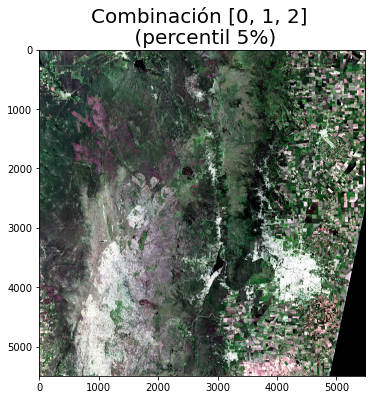

In [65]:
# plot_rgb(rgb,[0,1,2], p=5)

In [4]:
#directorio en donde esta la imagen
s2 = rasterio.open('Imagenes enero 2021/Sur_20mTODOS.tif') #Bandas 2,3,4 y 8 
s2_bandas = s2.read()
s2_bandas.shape #(cantidad de bandas, alto de la imagen, largo de la imagen)

(9, 10980, 10980)

In [5]:
#Sist. de coord
print(s2.crs)

#Extensión:
print(s2.bounds)

EPSG:32720
BoundingBox(left=300000.0, bottom=6390220.0, right=409800.0, top=6500020.0)


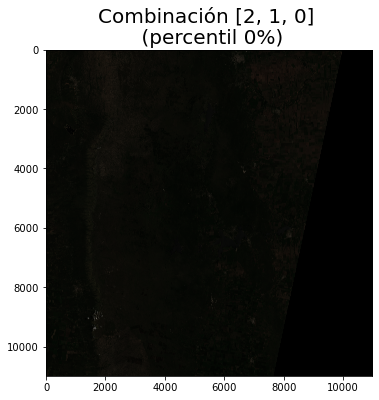

In [6]:
plot_rgb(s2_bandas, [2,1,0], p=0) #Plotea las bandas seleccionadas (indexado arranca en 0), con percentil 5%

In [5]:
radios = gpd.read_file('geometrias-corregidas/Embalses unificado.shp')#.set_index('id') #Levanta archivo shp
radios.drop(columns=['path', 'objeto','entidad','layer'], inplace = True)
radios['id'] = np.linspace(0,10,11).astype(int)
radios.set_index('id')

gid           fna  Superficie  \
id                                    
0   33857  Cerro Pelado       12.50   
1   30894   Los Molinos       19.40   
2   33861   Rio Tercero       46.44   
3   33879      Pichanas        4.09   
4   33880  Cruz del Eje       10.29   
5   33882      La ViÃ±a        5.67   
6   33884       Usina 3        2.67   
7   33885   Piedra Mora        8.75   
8    7814     San Roque       13.30   
9   33856  Arroyo Corto        3.33   
10  33881      El Cajon        1.10   

                                             geometry  
id                                                     
0   POLYGON ((344214.773 6437426.358, 344209.609 6...  
1   POLYGON ((352710.323 6479131.072, 352714.094 6...  
2   POLYGON ((365970.151 6439668.417, 365953.147 6...  
3   POLYGON ((291335.467 6578390.734, 291299.608 6...  
4   POLYGON ((332232.611 6595717.129, 332232.269 6...  
5   POLYGON ((307311.654 6472607.890, 307115.235 6...  
6   POLYGON ((375123.493 6437419.686, 375060.939 6...  
7   POLYGON ((375880.378 6437539.201, 375741.044 6...  
8   POLYGON ((362251.484 6527725.212, 362201.415 6...  
9   POLYGON ((351787.950 6434661.122, 351798.854 6...  
10  POLYGON ((351355.942 6585725.836, 351422.271 6...

In [7]:
radios.crs #metada del shp

<Derived Projected CRS: EPSG:32720>
Name: WGS 84 / UTM zone 20S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 66°W and 60°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Falkland Islands (Malvinas). Paraguay.
- bounds: (-66.0, -80.0, -60.0, 0.0)
Coordinate Operation:
- name: UTM zone 20S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
Norte = ['Cruz del Eje','San Roque','El Cajon']
Sur = ['Cerro Pelado','Los Molinos','Rio Tercero','La ViÃ±a','Usina 3','Piedra Mora','Arroyo Corto']

radiosN = radios.query('fna in @Norte')
radiosS = radios.query('fna in @Sur')
radiosS

gid           fna  Superficie  \
0  33857  Cerro Pelado       12.50   
1  30894   Los Molinos       19.40   
2  33861   Rio Tercero       46.44   
5  33882      La ViÃ±a        5.67   
6  33884       Usina 3        2.67   
7  33885   Piedra Mora        8.75   
9  33856  Arroyo Corto        3.33   

                                            geometry  id  
0  POLYGON ((344214.773 6437426.358, 344209.609 6...   0  
1  POLYGON ((352710.323 6479131.072, 352714.094 6...   1  
2  POLYGON ((365970.151 6439668.417, 365953.147 6...   2  
5  POLYGON ((307311.654 6472607.890, 307115.235 6...   5  
6  POLYGON ((375123.493 6437419.686, 375060.939 6...   6  
7  POLYGON ((375880.378 6437539.201, 375741.044 6...   7  
9  POLYGON ((351787.950 6434661.122, 351798.854 6...   9

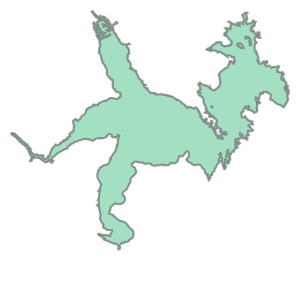

In [7]:
IDEmbalse = 2
nombre = radios.loc[IDEmbalse].fna
poligono = radios.loc[IDEmbalse].geometry #geometría del octavo elemento de shp
poligono

In [8]:
s2_plot_extent = plotting_extent(s2) #Bordes de la region a graficar
s2_plot_extent

(300000.0, 409800.0, 6390220.0, 6500020.0)

In [9]:
# Ploteo de la imagen con los poligonos encima

bandasPosicion = [0,1,2] #Norte
bandasPosicion = [2,1,0] #SUR


# img = nequalize(s2_bandas[bandasPosicion], p=5, nodata = None)
# fig, ax = plt.subplots(figsize = (15,8))
# show(img, ax=ax, extent = s2_plot_extent, cmap = 'gray')
# radiosS.boundary.plot(ax=ax, edgecolor = 'red')
# plt.show()

<AxesSubplot:>

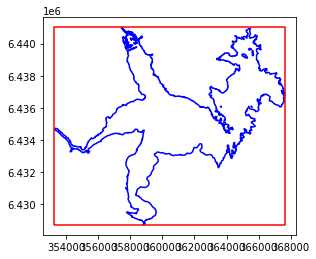

In [10]:
# RECORTO LA ZONA DE INTERES
extent = poligono.envelope

data = [poligono, extent]
gpd.GeoSeries(data).boundary.plot(color=['b', 'r'])

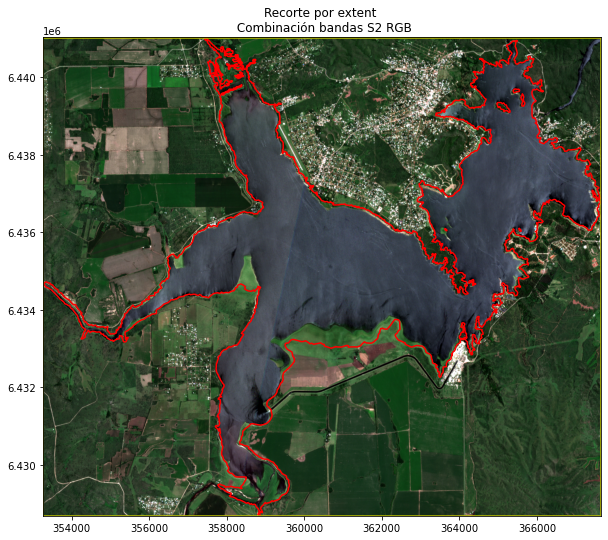

In [11]:
s2_clip, clip_transform = mask(dataset = s2, shapes = [extent], crop = True)
fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_clip[[2,1,0]],p=0.5,nodata = None), ax=ax, transform=clip_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por extent \n Combinación bandas S2 RGB")
plt.show()

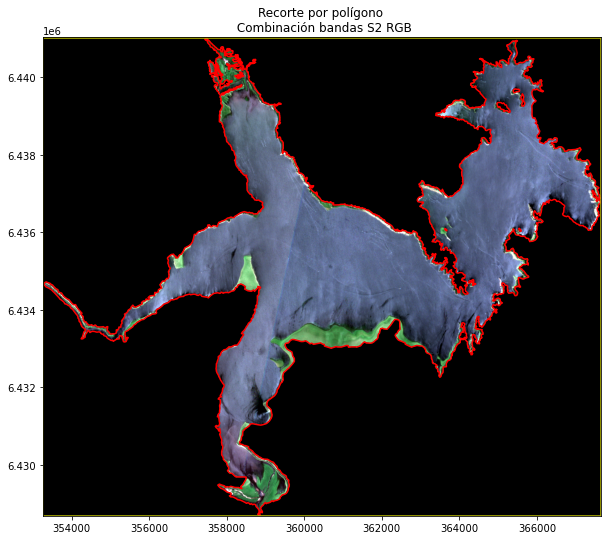

In [12]:
# Me quedo solo con lo dentro de la mascara vectorial
s2_mask, mask_transform  = mask(dataset = s2, shapes = [poligono], crop = True)

fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_mask[bandasPosicion], p=0.5), ax=ax,transform=mask_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por polígono \n Combinación bandas S2 RGB")
plt.show()

In [41]:
# s2_rgb = s2_mask[[2,1,0]]/10000
# s2_rgb = s2_rgb[s2_rgb!=0]

# plt.hist(s2_rgb.flatten(), 100); 

In [13]:
reescalado = 10000

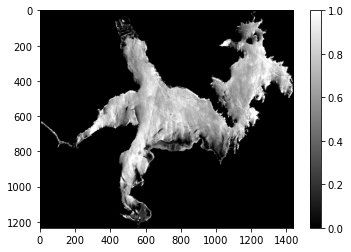

In [14]:
s2_mono = s2_mask[0]/reescalado
plt.imshow(nequalize(s2_mono, p = 5), cmap='gray')
plt.colorbar()

-----------------
Firmas espectrales
---------------

In [15]:
blue = delNone(s2_mask[bandasPosicion[0]],0,reescalado)
green = delNone(s2_mask[bandasPosicion[1]],0,reescalado)
red = delNone(s2_mask[bandasPosicion[2]],0,reescalado)
nir = delNone(s2_mask[3],0,reescalado)

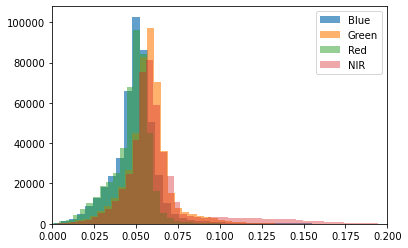

In [16]:
plt.hist(blue, 100, alpha = 0.7, label = 'Blue');
plt.hist(green, 100, alpha = 0.6, label = 'Green');
plt.hist(red, 100, alpha = 0.5, label = 'Red');
plt.hist(nir, 100, alpha = 0.4, label = 'NIR');
plt.xlim(0,0.2)
plt.legend()

In [17]:
#Calcula medias y desviacion estandar para cada banda

[mean_b, mean_g, mean_r, mean_nir] = [np.mean(blue), np.mean(green), np.mean(red), np.mean(nir)]
[std_b, std_g, std_r, std_nir] = [np.std(blue), np.std(green), np.std(red), np.std(nir)]

medias = [mean_b, mean_g, mean_r, mean_nir]
stds = np.asarray([std_b, std_g, std_r, std_nir])
# stds = np.asarray([std_b, std_g, std_r, std_nir])/(nir.shape[0]) 

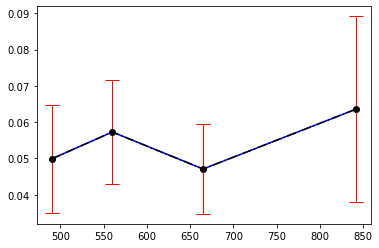

In [18]:
long = [490, 560, 665, 842]

#Quizas habría que utilizar el error estadistico y no la desviacion como el error
plt.errorbar(long, medias, marker = 'o', yerr = stds, elinewidth = 1, ls = '-.', color = 'k', ecolor = 'red', capsize=7)
plt.plot(long, medias, 'b')


In [19]:
means = []
desvs = []
for i in range(len(s2_mask)):
    aux = delNone(s2_mask[i],0,reescalado)
    means.append(np.mean(aux))
    desvs.append(np.std(aux))#/np.sqrt(len(aux)))
    
means = np.asarray(means)
desvs = np.asarray(desvs)

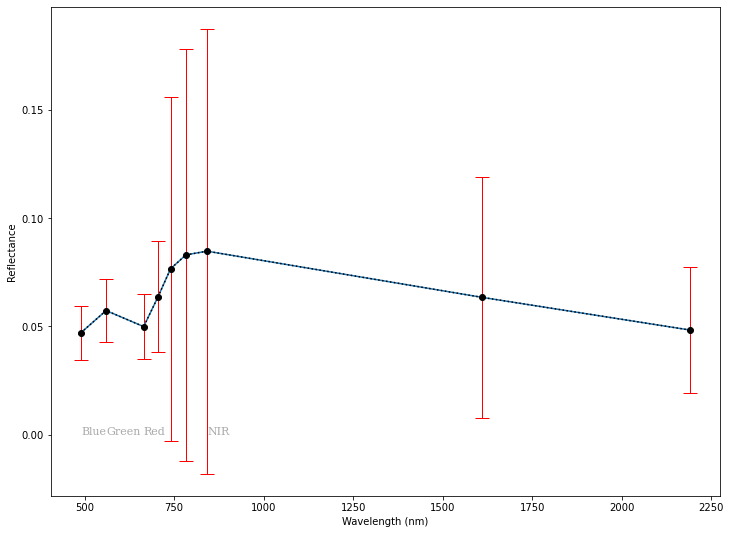

In [20]:
long = [490, 560, 665, 705, 740, 783, 842, 1610, 2190]


plt.figure(figsize = (12,9))
plt.errorbar(long, means, marker = 'o', yerr = desvs, elinewidth = 1, ls = 'dotted', color = 'k', ecolor = 'red', capsize=7)
plt.plot(long, means)#, label=l)
# plt.fill_between(long, means-desvs, (means+desvs), color='b', alpha=.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')

font = {'family':'serif', 'color':'darkgray', 'size':11}
for x,t in zip([490, 560, 665, 842], ['Blue','Green','Red','NIR']):
    plt.text(x-0.012, 0, t, fontdict=font)
    
plt.savefig('Firma_SanRoque.png', dpi = 300)

In [21]:
def guardar_GTiff(fn, crs, transform, mat, meta=None, nodata=None, bandnames=[]):
    if len(mat.shape)==2:
        count=1
    else:
        count=mat.shape[0]

    if not meta:
        meta = {}

    meta['driver'] = 'GTiff'
    meta['height'] = mat.shape[-2]
    meta['width'] = mat.shape[-1]
    meta['count'] = count
    meta['crs'] = crs
    meta['transform'] = transform

    if 'dtype' not in meta: #if no datatype is specified, use float32
        meta['dtype'] = np.float32
    

    if nodata==None:
        pass
    else:
        meta['nodata'] = nodata

    with rasterio.open(fn, 'w', **meta) as dst:
        if count==1: #es una matriz bidimensional, la guardo
            dst.write(mat.astype(meta['dtype']), 1)
            if bandnames:
                dst.set_band_description(1, bandnames[0])
        else: #es una matriz tridimensional, guardo cada banda
            for b in range(count):
                dst.write(mat[b].astype(meta['dtype']), b+1)
            for b,bandname in enumerate(bandnames):
                dst.set_band_description(b+1, bandname)#   
                

In [84]:
#Descomentar para guardar 
# guardar_GTiff('Procesados/S2_mask.tif', s2.crs, mask_transform, s2_mask, meta = {'dtype': 'uint16', 'nodata': 0})

-----------------------
Indices
--------

In [22]:
#Calculo NDVI
def ndvi(array, bandaR, bandaNIR, factor): 
    red = np.asarray(array[bandaR])/factor
    nir = np.asarray(array[bandaNIR])/factor
    
    return (nir-red)/(nir+red)

#Calculo NDWI
def ndwi(array, bandaG, bandaNIR,factor): 
    green = np.asarray(array[bandaG])/factor
    nir = np.asarray(array[bandaNIR])/factor
    
    return (green - nir)/(nir+green)

def indice(array, banda1, banda2, factor): #en la primera banda va el que esta sumando en el numerador
    aux1 = np.asarray(array[banda1])/factor
    aux2 = np.asarray(array[banda2])/factor
    
    return (aux1-aux2)/(aux1+aux2)

In [20]:
bandasPosicion[2]

0

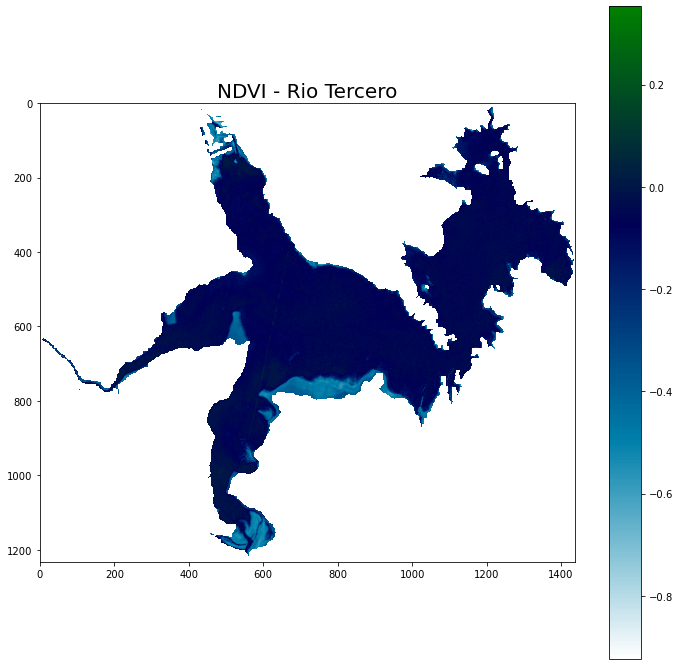

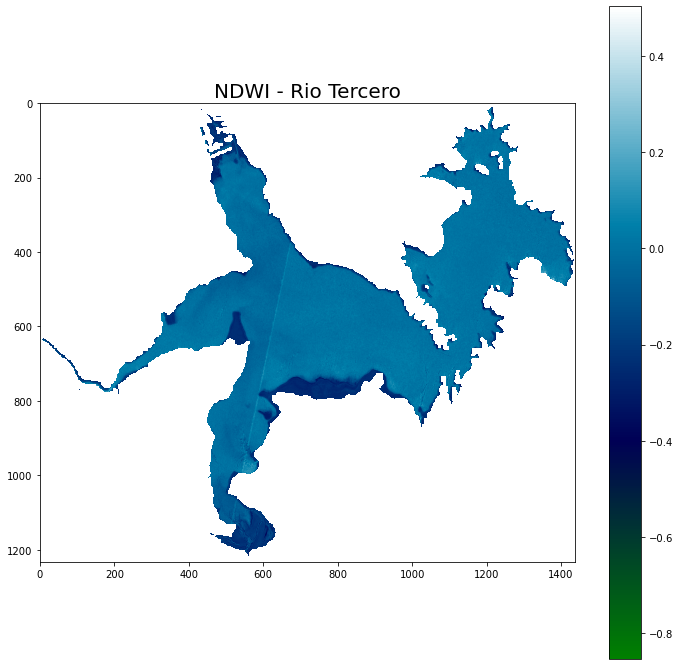

In [37]:
os.chdir("D:\\Documentos Facultad - Conicet\Cursos\Tele - UNSAM\Scipts")
# Documentos Facultad - Conicet/Cursos/Tele - UNSAM/Scipts/Plots
plt.figure(figsize=(12,12))
plt.imshow(ndvi(s2_mask,3,bandasPosicion[0], 10000), cmap='ocean_r')
plt.colorbar()
plt.title('NDVI - '+nombre,  fontsize = 20)

plt.savefig('Plots/ndvi_'+nombre+'.png', dpi = 300)

plt.figure(figsize=(12,12))
plt.imshow(ndwi(s2_mask,bandasPosicion[1],3,10000), cmap='ocean')
plt.colorbar()
plt.title('NDWI - '+nombre,  fontsize = 20)

plt.savefig('Plots/ndwi_'+nombre+'.png', dpi = 300)

os.chdir("C:\\Users\\arell\\Documents\\Sentinel")

In [23]:
indicesTC = [0,1,2,6,7,8]#Norte
indicesTC = [2,1,0,6,7,8]#Sur
matriz = []
matriz2 = []
coeficientesS2 = [[-0.3037, 0.2793, 0.4743, 0.5585, 0.5082, 0.1863],
                  [-0.2848, -0.2435, -0.5436, 0.7243, 0.0840, -0.1800],
                  [-0.1509, 0.1973, 0.3279, 0.3406, -0.7112, -0.4572]] 

for i in indicesTC:
    matriz.append(s2_clip[i]/reescalado)
    matriz2.append(s2_mask[i]/reescalado)
    
[brillo, verdor, humedad] = np.einsum('ij,jkl->ikl', coeficientesS2,matriz)
[brilloM, verdorM, humedadM] = np.einsum('ij,jkl->ikl', coeficientesS2,matriz2)

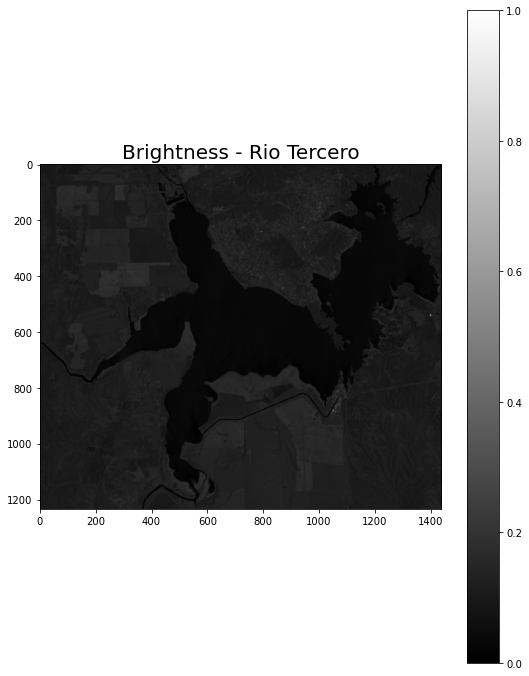

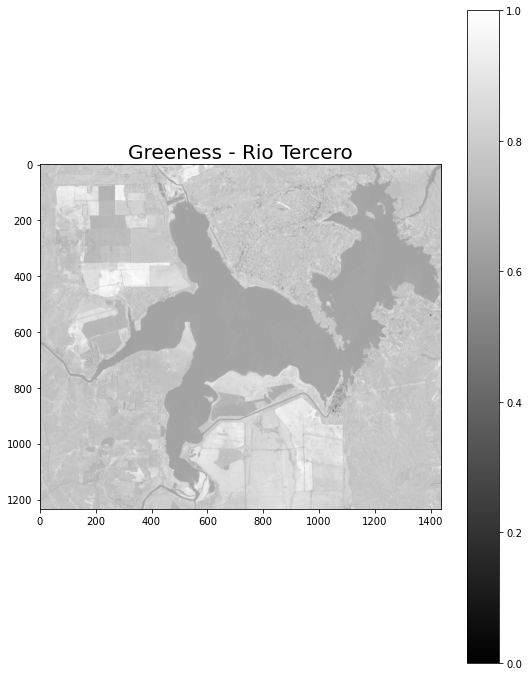

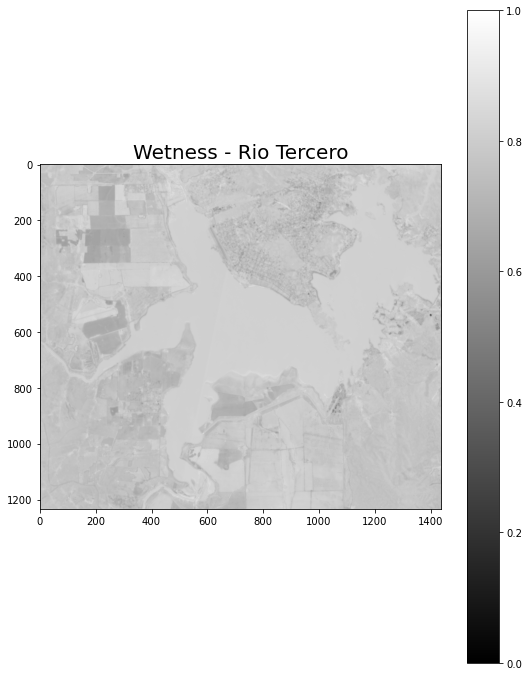

In [ ]:
# os.chdir("D:\\Documentos Facultad - Conicet\Cursos\Tele - UNSAM\Scipts")
# nombre += '-mask'

plt.figure(figsize = (9,12))
plt.imshow(nequalize(brillo,0,0.1), cmap='gray')
plt.colorbar()
plt.title('Brightness - '+nombre,  fontsize = 20)
plt.savefig('Plots/Brightness_'+nombre+'.png', dpi = 300)

plt.figure(figsize = (9,12))
plt.imshow(nequalize(verdor,0,0.1), cmap='gray')
plt.colorbar()
plt.title('Greeness - '+nombre,  fontsize = 20)
plt.savefig('Plots/Greeness_'+nombre+'.png', dpi = 300)

plt.figure(figsize = (9,12))
plt.imshow(nequalize(humedad,0,0.1), cmap='gray')
plt.colorbar()
plt.title('Wetness - '+nombre,  fontsize = 20)
plt.savefig('Plots/Wetness_'+nombre+'.png', dpi = 300)

# os.chdir("C:\\Users\\arell\\Documents\\Sentinel")

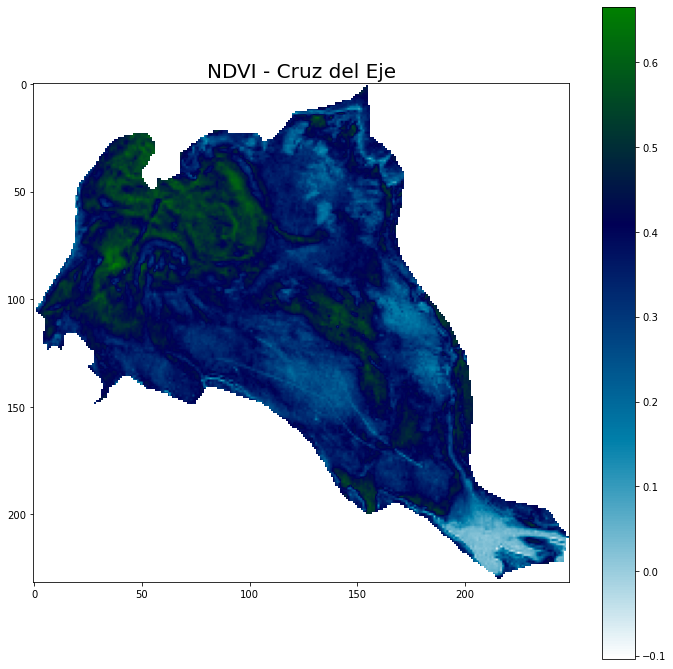

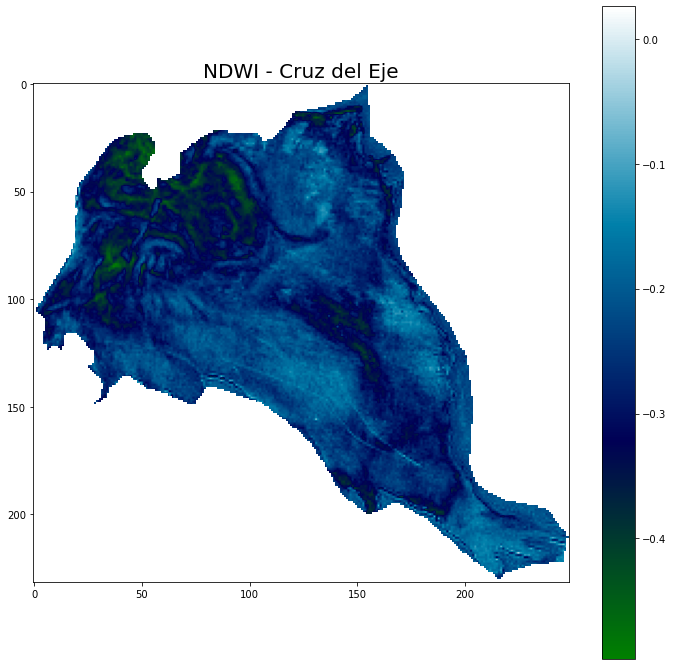

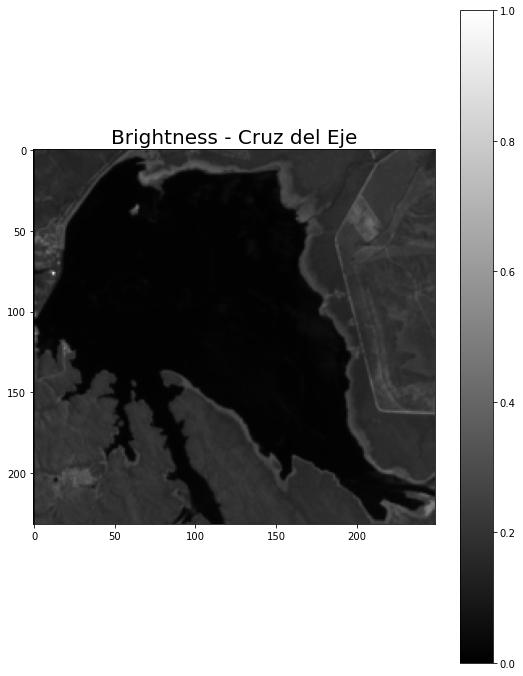

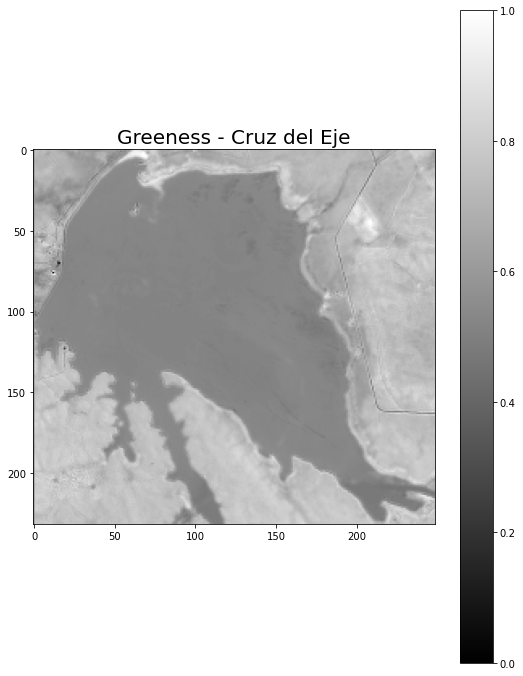

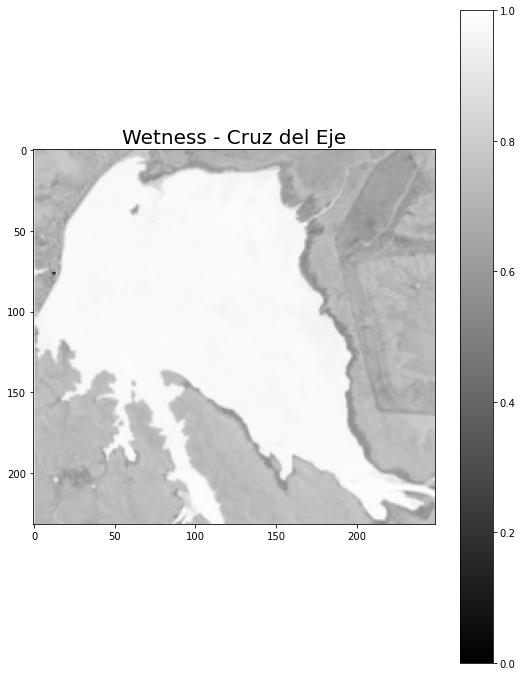

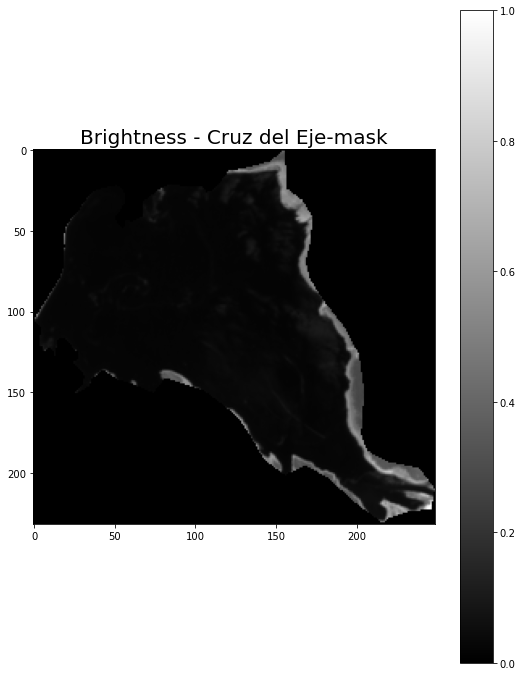

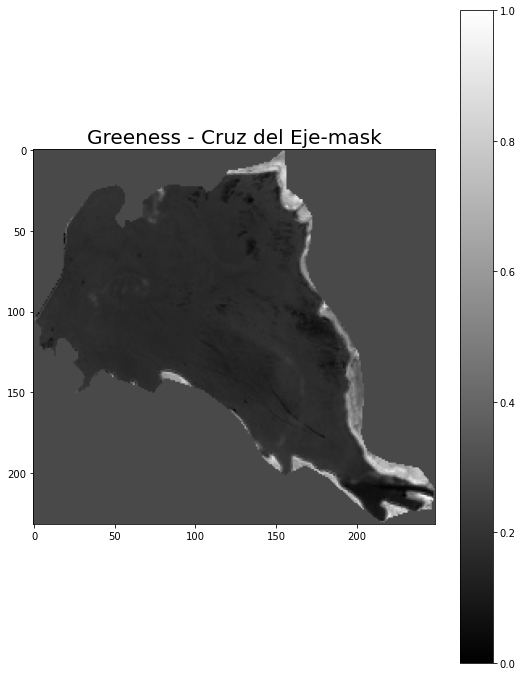

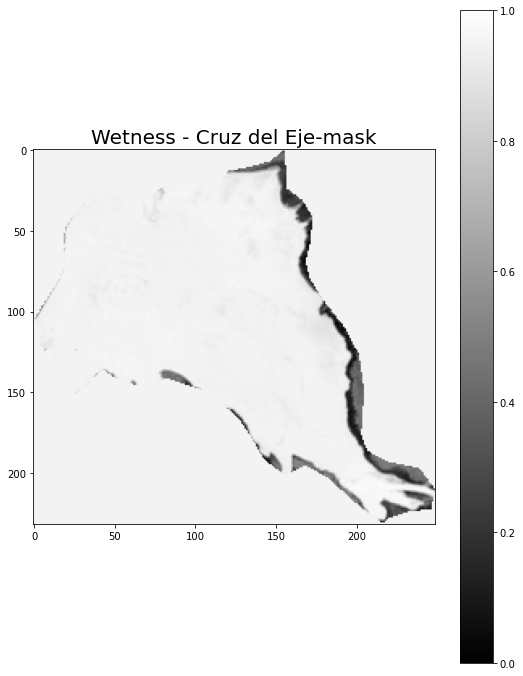

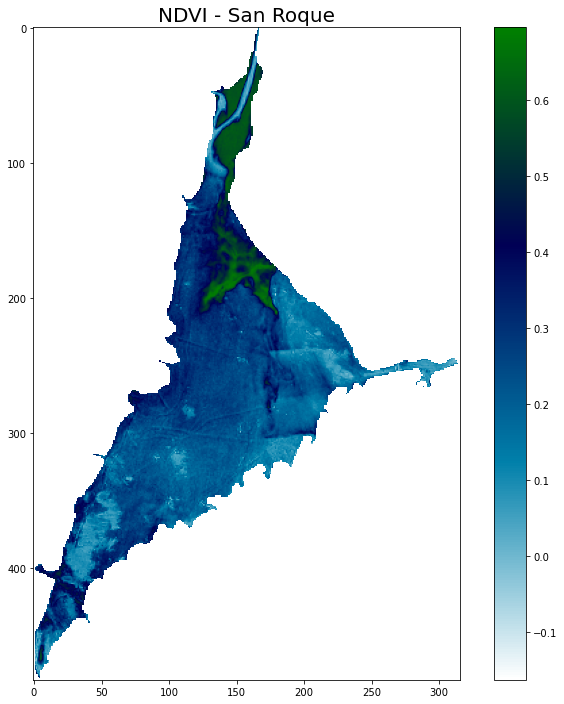

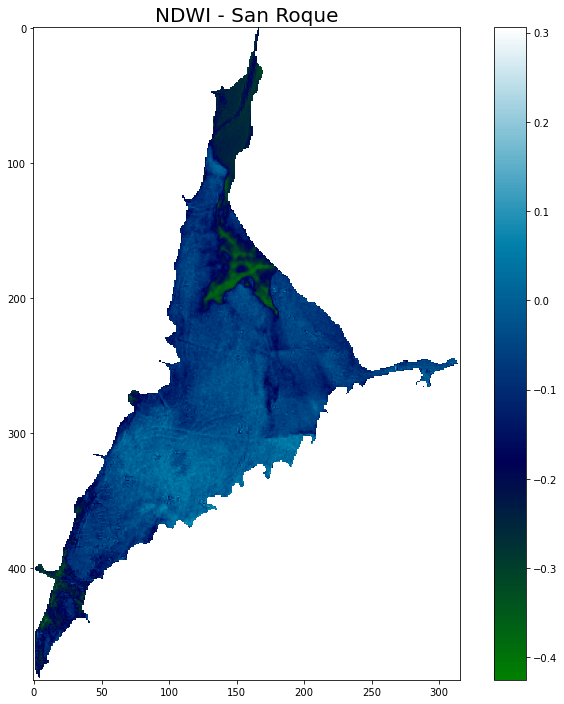

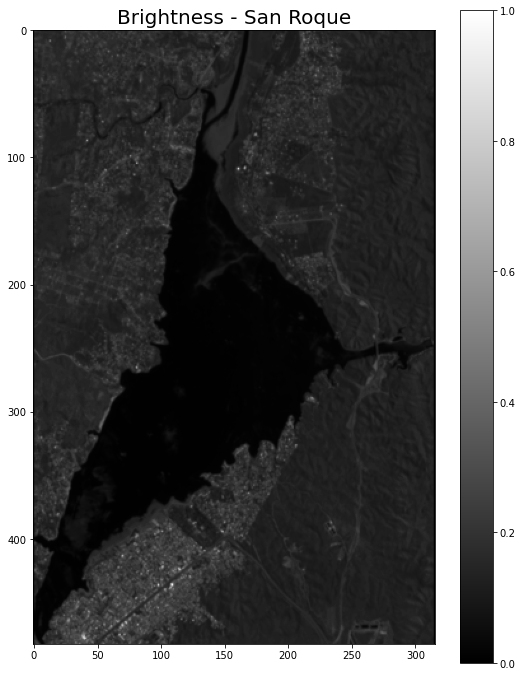

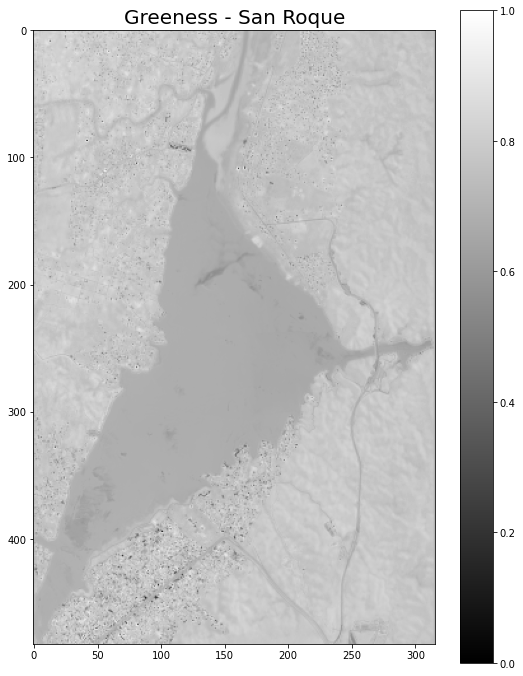

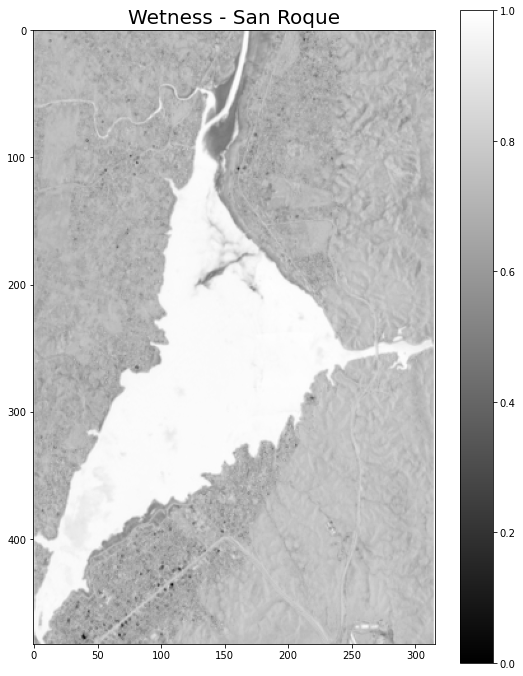

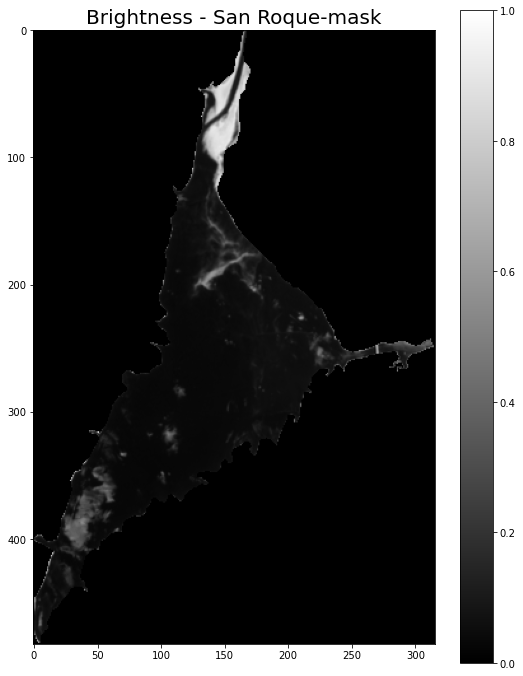

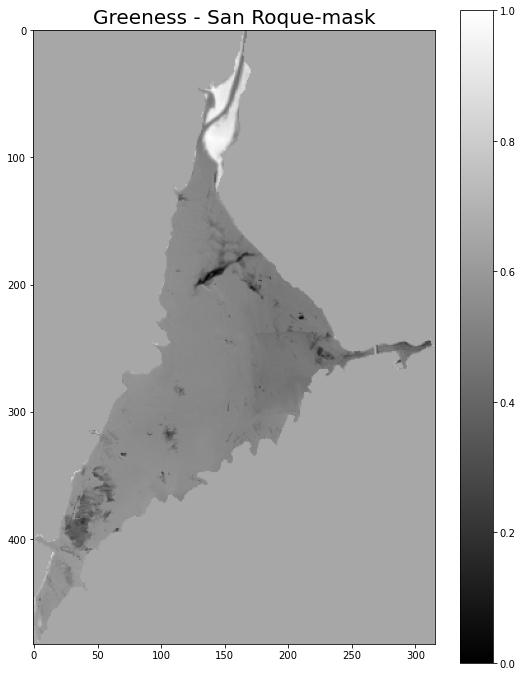

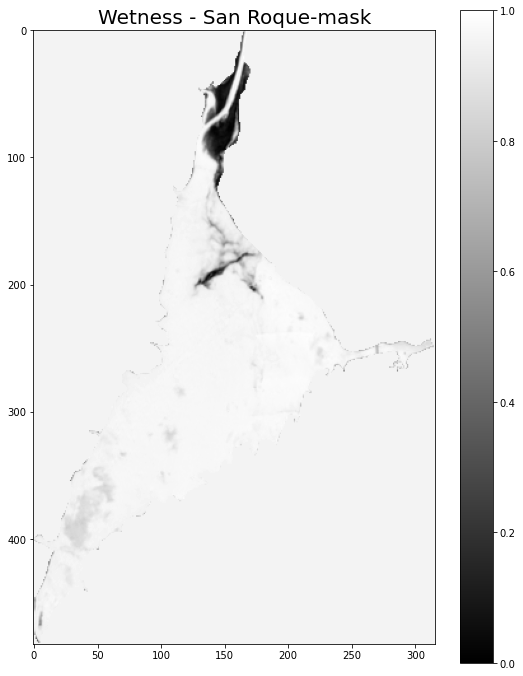

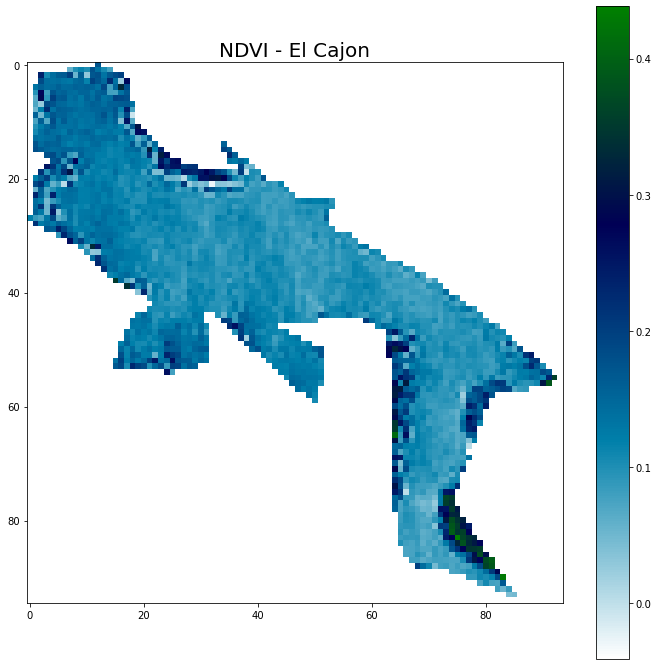

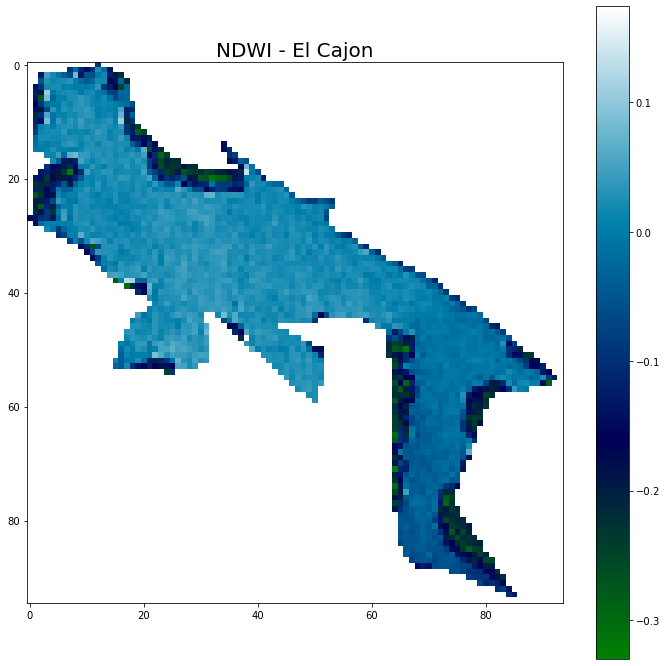

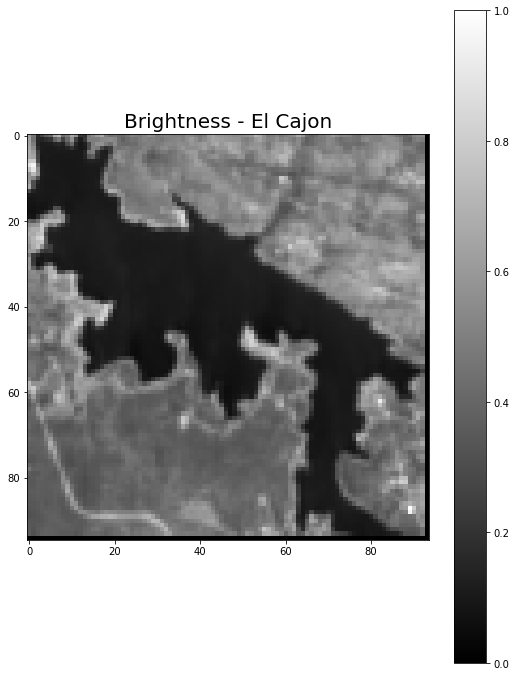

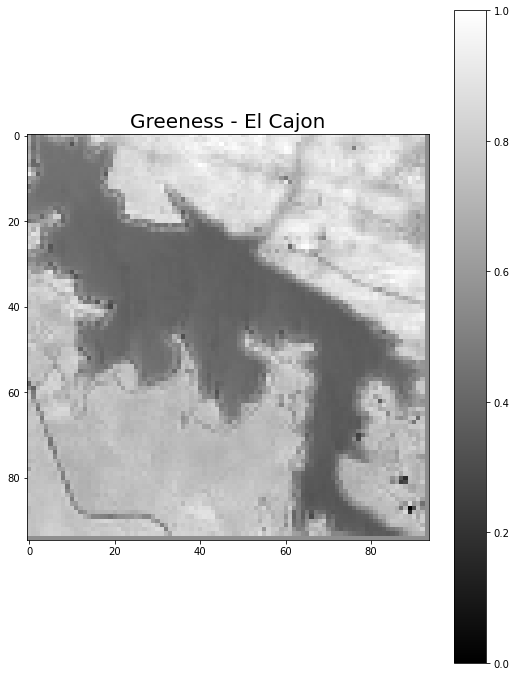

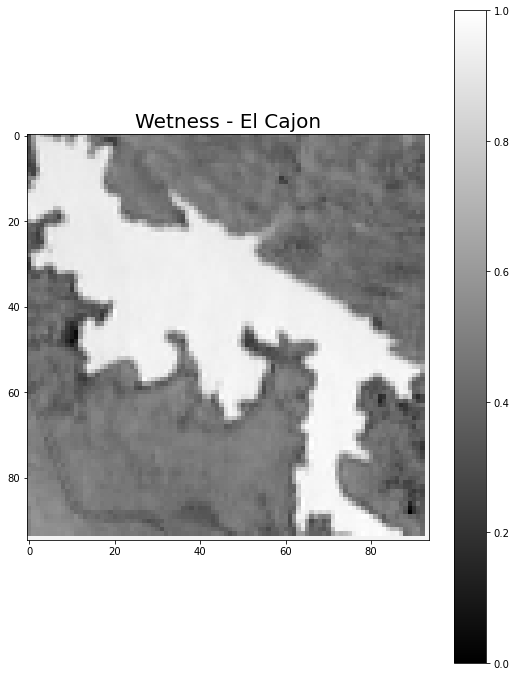

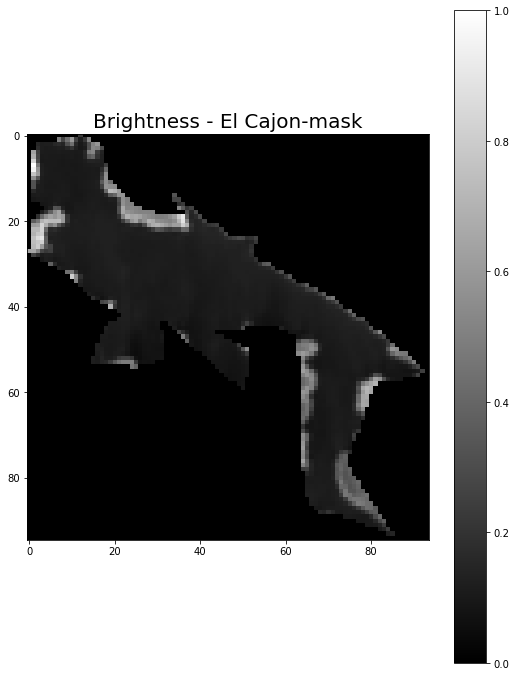

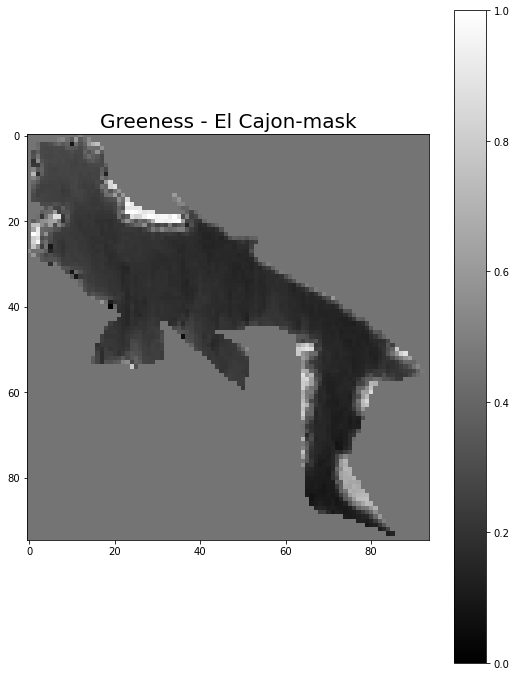

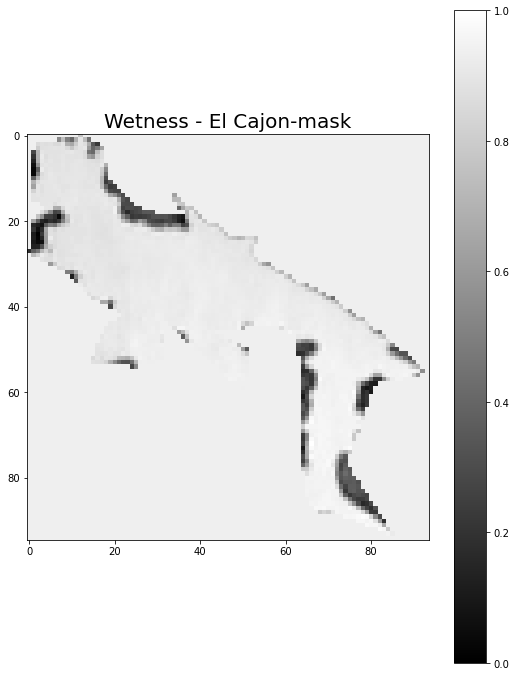

In [151]:
IDN = [4,8,10]
for ID in IDN:
    IDEmbalse = ID
    reescalado = 10000

    nombre = radios.loc[IDEmbalse].fna
    poligono = radios.loc[IDEmbalse].geometry #geometría del octavo elemento de shp
    s2_plot_extent = plotting_extent(s2) #Bordes de la region a graficar

    # RECORTO LA ZONA DE INTERES
    extent = poligono.envelope

    # data = [poligono, extent]
    # gpd.GeoSeries(data).boundary.plot(color=['b', 'r'])

    s2_clip, clip_transform = mask(dataset = s2, shapes = [extent], crop = True)
    s2_mask, mask_transform  = mask(dataset = s2, shapes = [poligono], crop = True)

    os.chdir("D:\\Documentos Facultad - Conicet\Cursos\Tele - UNSAM\Scipts")
    # Documentos Facultad - Conicet/Cursos/Tele - UNSAM/Scipts/Plots
    plt.figure(figsize=(12,12))
    plt.imshow(indice(s2_mask,3,2), cmap='ocean_r')
    plt.colorbar()
    plt.title('NDVI - '+nombre,  fontsize = 20)
    plt.savefig('Plots/ndvi_'+nombre+'.png', dpi = 300)

    plt.figure(figsize=(12,12))
    plt.imshow(indice(s2_mask,1,3), cmap='ocean')
    plt.colorbar()
    plt.title('NDWI - '+nombre,  fontsize = 20)
    plt.savefig('Plots/ndwi_'+nombre+'.png', dpi = 300)

    os.chdir("C:\\Users\\arell\\Documents\\Sentinel")

    indicesTC = [0,1,2,6,7,8]
    matriz = []
    matriz2 = []
    coeficientesS2 = [[-0.3037, 0.2793, 0.4743, 0.5585, 0.5082, 0.1863],
                      [-0.2848, -0.2435, -0.5436, 0.7243, 0.0840, -0.1800],
                      [-0.1509, 0.1973, 0.3279, 0.3406, -0.7112, -0.4572]] 

    for i in indicesTC:
        matriz.append(s2_clip[i]/reescalado)
        matriz2.append(s2_mask[i]/reescalado)

    [brillo, verdor, humedad] = np.einsum('ij,jkl->ikl', coeficientesS2,matriz)
    [brilloM, verdorM, humedadM] = np.einsum('ij,jkl->ikl', coeficientesS2,matriz2)

    os.chdir("D:\\Documentos Facultad - Conicet\Cursos\Tele - UNSAM\Scipts")
    # nombre += '-mask'

    plt.figure(figsize = (9,12))
    plt.imshow(nequalize(brillo,0,5), cmap='gray')
    plt.colorbar()
    plt.title('Brightness - '+nombre,  fontsize = 20)
    plt.savefig('Plots/Brightness_'+nombre+'.png', dpi = 300)

    plt.figure(figsize = (9,12))
    plt.imshow(nequalize(verdor,0,5), cmap='gray')
    plt.colorbar()
    plt.title('Greeness - '+nombre,  fontsize = 20)
    plt.savefig('Plots/Greeness_'+nombre+'.png', dpi = 300)

    plt.figure(figsize = (9,12))
    plt.imshow(nequalize(humedad,0,5), cmap='gray')
    plt.colorbar()
    plt.title('Wetness - '+nombre,  fontsize = 20)
    plt.savefig('Plots/Wetness_'+nombre+'.png', dpi = 300)

    os.chdir("C:\\Users\\arell\\Documents\\Sentinel")

    os.chdir("D:\\Documentos Facultad - Conicet\Cursos\Tele - UNSAM\Scipts")
    nombre += '-mask'

    plt.figure(figsize = (9,12))
    plt.imshow(nequalize(brilloM,0,5), cmap='gray')
    plt.colorbar()
    plt.title('Brightness - '+nombre,  fontsize = 20)
    plt.savefig('Plots/Brightness_'+nombre+'.png', dpi = 300)

    plt.figure(figsize = (9,12))
    plt.imshow(nequalize(verdorM,0,5), cmap='gray')
    plt.colorbar()
    plt.title('Greeness - '+nombre,  fontsize = 20)
    plt.savefig('Plots/Greeness_'+nombre+'.png', dpi = 300)

    plt.figure(figsize = (9,12))
    plt.imshow(nequalize(humedadM,0,5), cmap='gray')
    plt.colorbar()
    plt.title('Wetness - '+nombre,  fontsize = 20)
    plt.savefig('Plots/Wetness_'+nombre+'.png', dpi = 300)

    os.chdir("C:\\Users\\arell\\Documents\\Sentinel")

------------
Estadisticas
----------

In [42]:
data=pd.DataFrame({'B':blue,'G':green,'R':red,'NIR':nir})#,'NDVI':ndvi(s2_mask,2,3).flatten()})#,'clase':[clases[y] for y in Y]})

<AxesSubplot:>

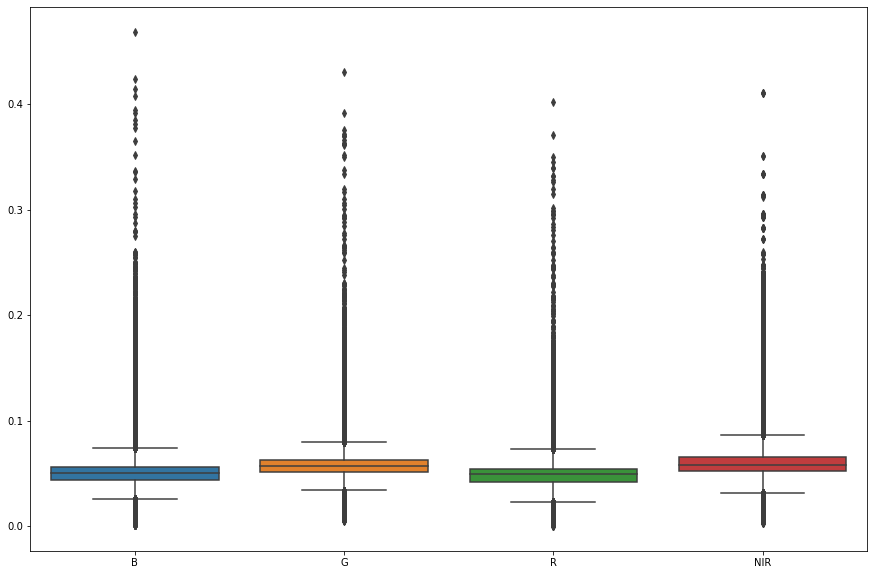

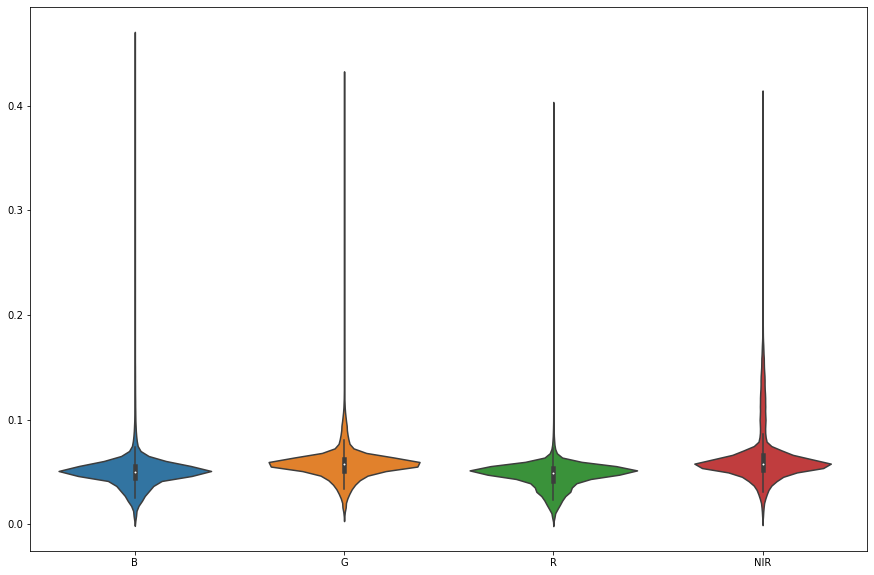

In [43]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data)#,x='clase', y='NDVI')
# plt.savefig('SalidasSur/boxplot.png',dpi=200)
fig = plt.figure(figsize=(15,10))
sns.violinplot(data=data)#,x='clase', y='NDVI')
# plt.savefig('SalidasSur/violinlot.png',dpi=200)

<AxesSubplot:xlabel='R', ylabel='G'>

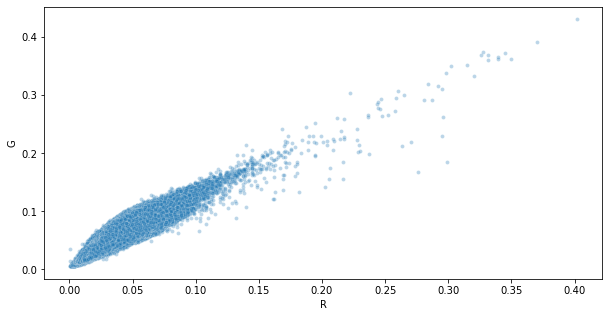

In [45]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='R', y='G', alpha=0.3, s=15)
# plt.savefig('SalidasSur/scatterplot.png')

Text(0, 0.5, 'Counts')

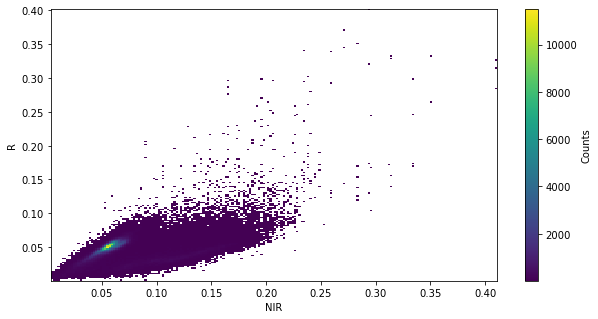

In [46]:
bandx = 'NIR'
bandy = 'R'
# Estimate the 2D histogram
nbins = 200
H, xedges, yedges = np.histogram2d(data[bandx],data[bandy],bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
 
# Plot 2D histogram using pcolor
fig2 = plt.figure(figsize=(10,5))
# sns.jointplot(data=data, x=bandx, y=bandy)l<
plt.pcolormesh(xedges,yedges,Hmasked)
plt.xlabel(bandx)
plt.ylabel(bandy)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')

In [ ]:
plt.figure()
sns.jointplot(data=data, x=bandx, y=bandy, kind='kde', fill=True)
plt.savefig('SalidasSur/scatterplot.png',dpi=200)

In [28]:
blue.shape

(464284,)

In [103]:
bluee = s2_mask[0]/10000
greenn = s2_mask[1]/10000
redd = s2_mask[2]/10000
nirr = s2_mask[3]/10000

redd[redd == 0] = np.nan
greenn[greenn == 0] = np.nan
bluee[bluee == 0] = np.nan
nirr[nirr == 0] = np.nan 

# plt.hist(redd[np.isfinite(redd)], 50);
# plt.hist(redd.flatten(), 50);

In [24]:
bluee = s2_mask[0]/10000
greenn = s2_mask[1]/10000
redd = s2_mask[2]/10000
nirr = s2_mask[3]/10000

bluee2 = bluee[(bluee!=0)]
greenn2 = greenn[greenn!=0]
redd2 = redd[redd!=0]
nirr2 = nirr[nirr!=0]

In [116]:
np.where(bluee2 == np.max(bluee2))

(array([350304], dtype=int64),)

In [117]:
max(bluee2)

0.199

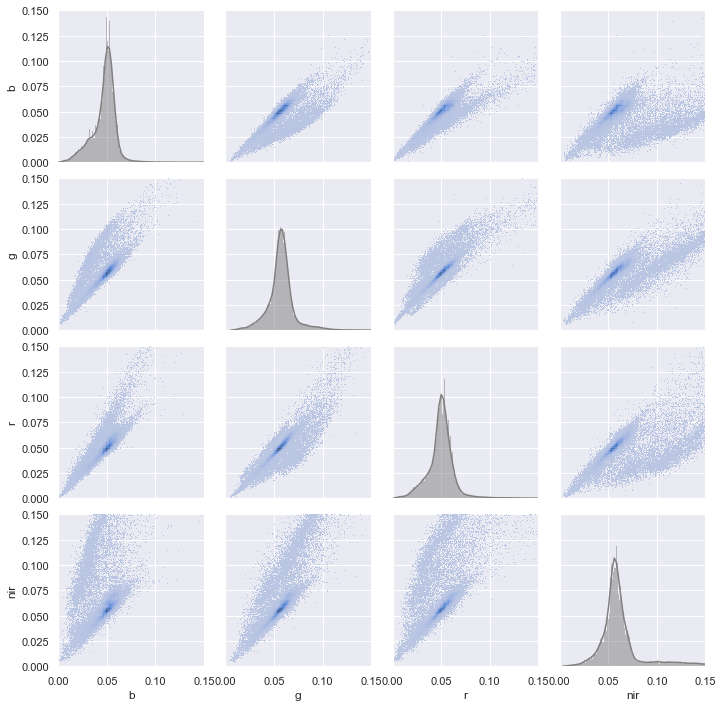

In [125]:
# stack_data = np.stack((bluee[np.isfinite(bluee)],greenn[np.isfinite(greenn)],redd[np.isfinite(redd)],nirr[np.isfinite(nirr)])).T
stack_data2 = np.stack((bluee2, greenn2, redd2, nirr2)).T
data = pd.DataFrame(stack_data2, columns = ['b','g','r','nir'])

f = sns.PairGrid(data)
# f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
f.map_upper(sns.histplot)
f.map_lower(sns.histplot)
f.map_diag(sns.histplot, kde=True, color='.5')
f.set(xlim = (0,0.15), ylim = (0,0.15))

In [25]:
# stack_data = np.stack((bluee[np.isfinite(bluee)],greenn[np.isfinite(greenn)],redd[np.isfinite(redd)],nirr[np.isfinite(nirr)])).T
stack_data2 = np.stack((bluee2, greenn2, redd2, nirr2)).T
data = pd.DataFrame(stack_data2, columns = ['b','g','r','nir'])

# f = sns.PairGrid(data)
# # f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
# f.map_upper(sns.kdeplot, fill = True)
# f.map_lower(sns.histplot)
# f.map_diag(sns.histplot, kde=True, color='.5')
# f.set(xlim = (0,0.15), ylim = (0,0.15))

In [26]:
S = np.zeros((6,6))
b_mean = np.mean(data['b'])

b       g       r     nir
0       0.0272  0.0550  0.0342  0.0844
1       0.0250  0.0526  0.0316  0.0775
2       0.0239  0.0519  0.0308  0.0844
3       0.0300  0.0582  0.0344  0.0844
4       0.0175  0.0399  0.0219  0.0710
...        ...     ...     ...     ...
464279  0.0281  0.0380  0.0354  0.0657
464280  0.0242  0.0459  0.0315  0.0780
464281  0.0248  0.0502  0.0349  0.0780
464282  0.0298  0.0393  0.0377  0.0657
464283  0.0254  0.0494  0.0315  0.0808

[464284 rows x 4 columns]

In [27]:
data.mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of              b       g       r     nir
0       0.0272  0.0550  0.0342  0.0844
1       0.0250  0.0526  0.0316  0.0775
2       0.0239  0.0519  0.0308  0.0844
3       0.0300  0.0582  0.0344  0.0844
4       0.0175  0.0399  0.0219  0.0710
...        ...     ...     ...     ...
464279  0.0281  0.0380  0.0354  0.0657
464280  0.0242  0.0459  0.0315  0.0780
464281  0.0248  0.0502  0.0349  0.0780
464282  0.0298  0.0393  0.0377  0.0657
464283  0.0254  0.0494  0.0315  0.0808

[464284 rows x 4 columns]>

<AxesSubplot:xlabel='r', ylabel='b'>

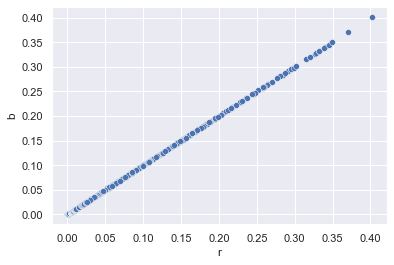

In [102]:
sns.scatterplot(data = data, x = 'r', y = 'b')